<a href="https://colab.research.google.com/github/dujest/yolov5-workshop/blob/main/YOLOv5_Custom_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Training with YOLOv5

In this tutorial, we assemble a dataset and train a custom YOLOv5 model to recognize the objects in our dataset. To do so we will take the following steps:

* Gather a dataset of images and label our dataset
* Export our dataset to YOLOv5
* Train YOLOv5 to recognize the objects in our dataset
* Evaluate our YOLOv5 model's performance
* Run test inference to view our model at work



![](https://uploads-ssl.webflow.com/5f6bc60e665f54545a1e52a5/615627e5824c9c6195abfda9_computer-vision-cycle.png)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
%cd ./drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!mkdir ./colab

In [ ]:
%cd ./colab

/content/drive/MyDrive/colab


# Step 1: Install Requirements

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# Step 2: Get a Dataset

In [ ]:
!mkdir ../dataset

In [ ]:
!wget "https://public.roboflow.com/ds/CqyHC2FLyj?key=IpdVLDwI0i" -O "/content/drive/MyDrive/colab/dataset/aerial_maritime_dataset.zip"

In [ ]:
!unzip "/content/drive/MyDrive/colab/dataset/aerial_maritime_dataset.zip" -d "/content/drive/MyDrive/colab/dataset/"
!rm "/content/drive/MyDrive/colab/dataset/aerial_maritime_dataset.zip"

**The dataset comprises 508 images of aerial maritime photographs taken with via a Mavic Air 2 drone and 1,151 bounding boxes, consisting of docks, boats, lifts, jetskis, and cars.**

**No augmentation steps were applied in this dataset.**

# Step 3: Train a Custom YOLOv5 model

**The initial values in this notebook were used for the image size, batch size and number of epochs. While, before every run, the weight were reset by setting the next command --weights "".**

In [ ]:
!python train.py --img 416 --batch -1 --epochs 150 --data /content/drive/MyDrive/colab/dataset/data.yaml --weights "" --cache --cfg /content/drive/MyDrive/colab/yolov5/models/yolov5m.yaml --optimizer "SGD" --project "../train/SGD"

In [ ]:
!python train.py --img 416 --batch -1 --epochs 150 --data /content/drive/MyDrive/colab/dataset/data.yaml --weights "" --cache --cfg /content/drive/MyDrive/colab/yolov5/models/yolov5m.yaml --optimizer "Adam" --project "../train/Adam"

## Evaluate Custom YOLOv5 Detector Performance
Training losses and performance metrics are saved to Tensorboard and also to a logfile.

If you are new to these metrics, the one you want to focus on is `mAP_0.5` - learn more about mean average precision [here](https://blog.roboflow.com/mean-average-precision/).

In [ ]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir ../train/

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

metrics_list = ['metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'metrics/precision', 'metrics/recall']

plt.rcParams["figure.figsize"] = (10,10)

def metrics_plotting(path_list, num):
    for n, metric in enumerate (metrics_list):
        n += 1
        plt.subplot(2, 2, n)
        for path in path_list:
            data = pd.read_csv(path_list[path], sep=',', header=0, skipinitialspace=True)
            data.rename(columns={metric : path}, inplace=True)
            spline = make_interp_spline(data['epoch'], data[path])
            epochs = np.linspace(0, len(data), num)
            spline_values = spline(epochs)
            spline_values[-1]=data[path].to_numpy()[-1]
            plt.plot('epoch', path, data=data, linestyle=':', linewidth=1, alpha=0.8)
            plt.plot(epochs, spline_values, linewidth=2, label=path)
        plt.title(metric)
        plt.xlabel('epoch')
        plt.legend()
    plt.show()

In [ ]:
def metrics_table(path_list):
    for n, path in enumerate(path_list):
        train_data = pd.read_csv(path_list[path], sep=',', header=0, skipinitialspace=True)
        train_data.rename(index={len(train_data)-1 : path}, inplace=True)
        train_metrics = train_data.iloc[:, [4, 5, 6, 7]]
        comparison_data = train_metrics.tail(1)
        if n == 0:
            comparsion_table = pd.concat([comparison_data])
        else:
            comparsion_table = pd.concat([comparsion_table, comparison_data])   

    return comparsion_table

In [ ]:
%cd /content/drive/MyDrive/colab/yolov5

In [ ]:
path_list_1 = {'SGD': '../train/SGD/exp/results.csv',
               'Adam': '../train/Adam/exp/results.csv'
              }

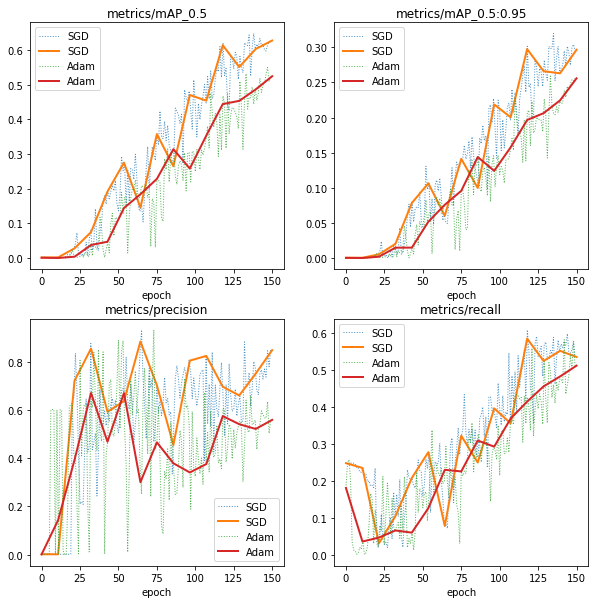

,metrics/precision,metrics/recall,metrics/mAP_0.5,metrics/mAP_0.5:0.95
SGD,0.84836,0.53411,0.62747,0.29661
Adam,0.55910,0.51073,0.52443,0.25591


In [ ]:
metrics_plotting(path_list=path_list_1, num=15)
metrics_table(path_list=path_list_1)

**The SGD optimization algorithm outperformed Adam for 20% in the mean Average Precision (mAP) and only 2% in recall. While the mAP for the Intersection over Union (IoU) of 50% is higer 10%.**

**Let's reduce the batch size and compare the results.**

In [ ]:
!python train.py --img 416 --batch 32 --epochs 150 --data /content/drive/MyDrive/colab/dataset/data.yaml --weights "" --cache --cfg /content/drive/MyDrive/colab/yolov5/models/yolov5m.yaml --optimizer "SGD" --project "../train/SGD_batch_32"

In [ ]:
!python train.py --img 416 --batch 32 --epochs 150 --data /content/drive/MyDrive/colab/dataset/data.yaml --weights "" --cache --cfg /content/drive/MyDrive/colab/yolov5/models/yolov5m.yaml --optimizer "Adam" --project "../train/Adam_batch_32"

In [ ]:
%tensorboard --logdir ../train/

In [ ]:
path_list_2 = {'SGD': '../train/SGD/exp/results.csv',
               'SGD_32': '../train/SGD_batch_32/exp/results.csv',
               'Adam': '../train/Adam/exp/results.csv',
               'Adam_32': '../train/Adam_batch_32/exp/results.csv'
              }

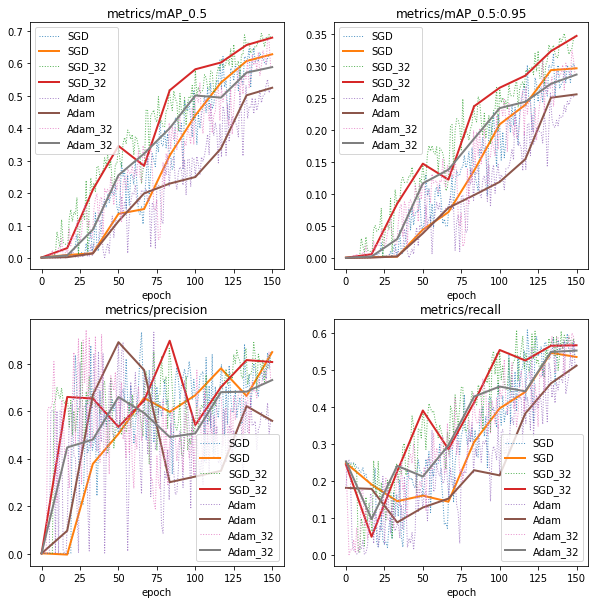

,metrics/precision,metrics/recall,metrics/mAP_0.5,metrics/mAP_0.5:0.95
SGD,0.84836,0.53411,0.62747,0.29661
SGD_32,0.80665,0.56557,0.67869,0.34726
Adam,0.55910,0.51073,0.52443,0.25591
Adam_32,0.73087,0.55131,0.58788,0.28687


In [ ]:
metrics_plotting(path_list=path_list_2, num=10)
metrics_table(path_list=path_list_2)

**This time Adam performed much better but again the SGD optimization algorithm is faster and gives slightly better results.**

In [ ]:
!python train.py --img 416 --batch 16 --epochs 150 --data /content/drive/MyDrive/colab/dataset/data.yaml --weights "" --cache --cfg /content/drive/MyDrive/colab/yolov5/models/yolov5m.yaml --optimizer "SGD" --project "../train/SGD_batch_16"

In [ ]:
!python train.py --img 416 --batch 16 --epochs 150 --data /content/drive/MyDrive/colab/dataset/data.yaml --weights "" --cache --cfg /content/drive/MyDrive/colab/yolov5/models/yolov5m.yaml --optimizer "Adam" --project "../train/Adam_batch_16"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ../train/

In [ ]:
path_list_3 = {'SGD_32': '../train/SGD_batch_32/exp/results.csv',
               'SGD_16': '../train/SGD_batch_16/exp/results.csv',
               'Adam_32': '../train/Adam_batch_32/exp/results.csv',
               'Adam_16': '../train/Adam_batch_16/exp/results.csv'
              }

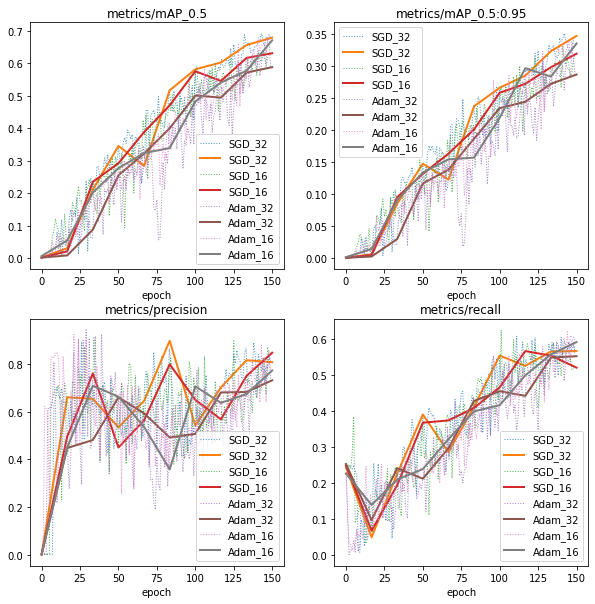

,metrics/precision,metrics/recall,metrics/mAP_0.5,metrics/mAP_0.5:0.95
SGD_32,0.80665,0.56557,0.67869,0.34726
SGD_16,0.84613,0.51963,0.63062,0.31948
Adam_32,0.73087,0.55131,0.58788,0.28687
Adam_16,0.77179,0.59057,0.67055,0.33534


In [ ]:
metrics_plotting(path_list=path_list_3, num=10)
metrics_table(path_list=path_list_3)

**After the last two runs, arguably, Adam performs better with the smaller batch size, with the mAP_0.5 higher for almost 10% and slightly better than SGD with the batch size of 16. On the other side, the performance of SGD decreased.**

**At the end, let's try the AdamW algorithm for a batch size of 16.**

In [ ]:
!python train.py --img 416 --batch 16 --epochs 150 --data /content/drive/MyDrive/colab/dataset/data.yaml --weights "" --cache --cfg /content/drive/MyDrive/colab/yolov5/models/yolov5m.yaml --optimizer "AdamW" --project "../train/AdamW_batch_16"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ../train/

In [ ]:
path_list_4 = {'Adam_32': '../train/Adam_batch_32/exp/results.csv',
               'Adam_16': '../train/Adam_batch_16/exp/results.csv',
               'AdamW_16': '../train/AdamW_batch_16/exp/results.csv'
              }

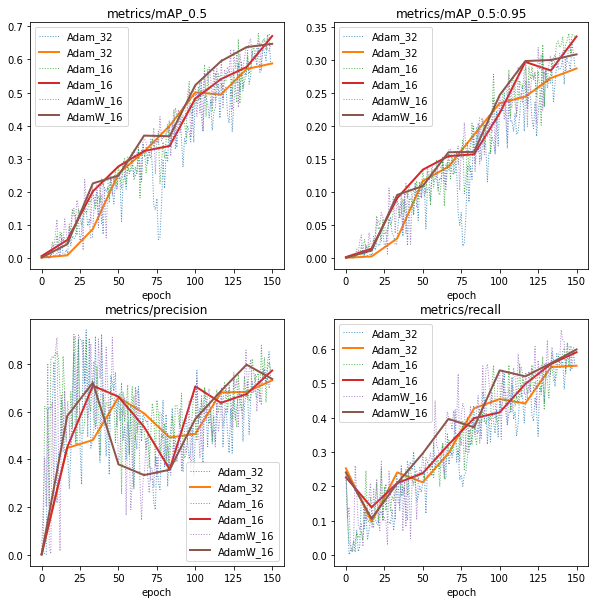

,metrics/precision,metrics/recall,metrics/mAP_0.5,metrics/mAP_0.5:0.95
Adam_32,0.73087,0.55131,0.58788,0.28687
Adam_16,0.77179,0.59057,0.67055,0.33534
AdamW_16,0.73638,0.59863,0.64706,0.30822


In [ ]:
metrics_plotting(path_list=path_list_4, num=10)
metrics_table(path_list=path_list_4)

**Surprisingly, AdamW did not show better performance than Adam.**

# Step 4: Run Inference With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
!python detect.py --weights /content/drive/MyDrive/colab/train/SGD_batch_32/exp/weights/best.pt --img 416 --conf 0.25 --source /content/drive/MyDrive/colab/dataset/test/images --line-thickness 2

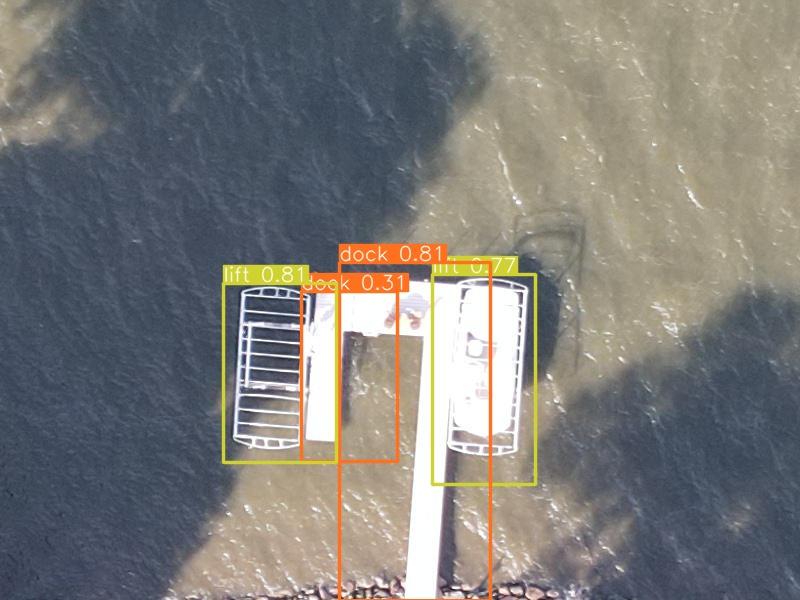

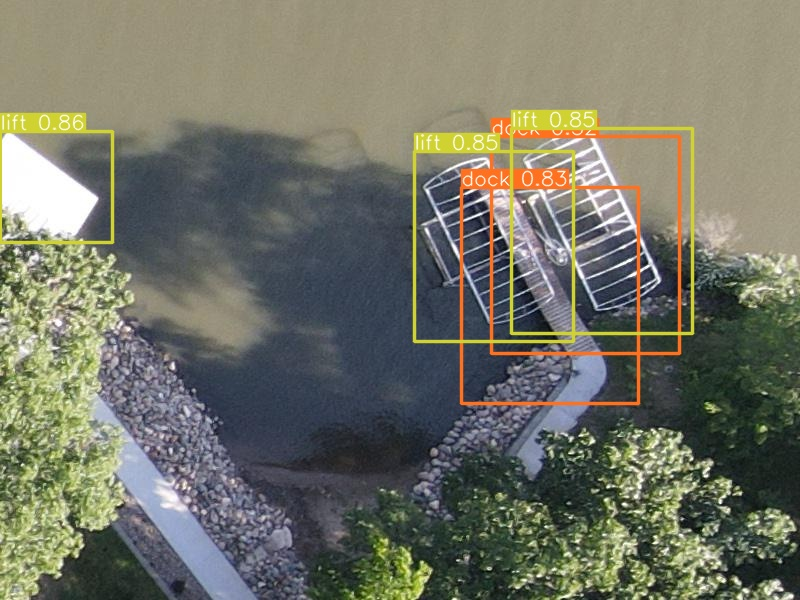

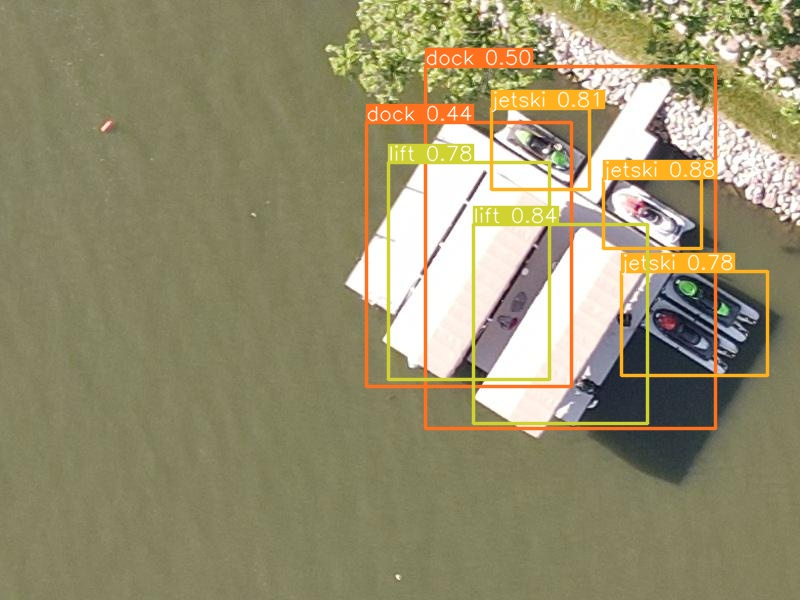

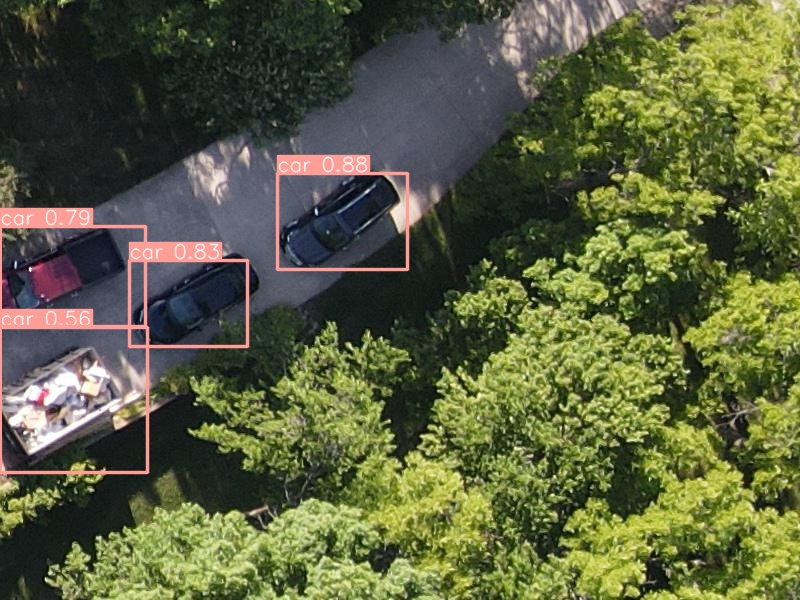

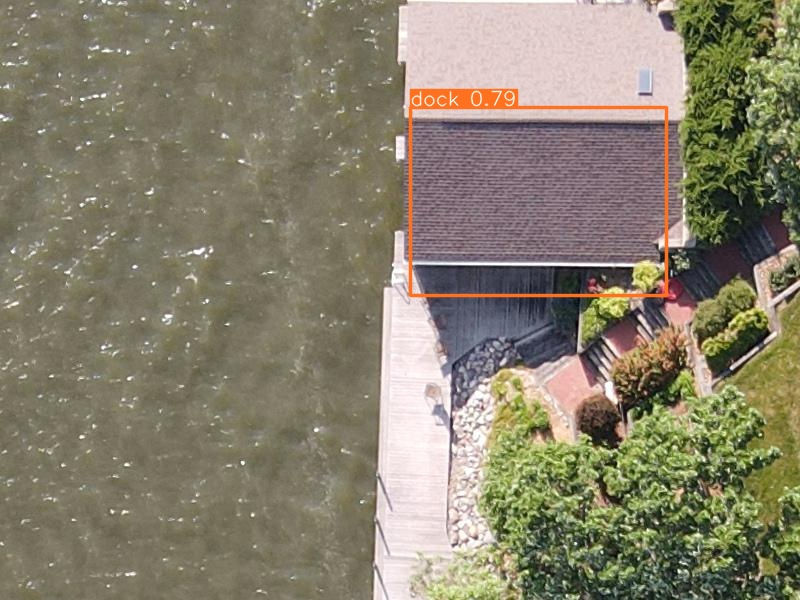

In [ ]:
from IPython.display import Image, display

image_path = {
    'image1' : '/content/drive/MyDrive/colab/yolov5/runs/detect/exp/DJI_0289_JPG.rf.7d2ce495fb2d3a19962e761e718c3a5e.jpg',
    'image2' : '/content/drive/MyDrive/colab/yolov5/runs/detect/exp/DJI_0267_JPG.rf.db20ca9a45bd94fa1000aac86f0adbab.jpg',
    'image3' : '/content/drive/MyDrive/colab/yolov5/runs/detect/exp/DJI_0312_JPG.rf.544df0e3a7b2778052c9110942b032a7.jpg',
    'image4' : '/content/drive/MyDrive/colab/yolov5/runs/detect/exp/DJI_0316_JPG.rf.2406ceec1ba7c548483c4f2e33c674b9.jpg',
    'image5' : '/content/drive/MyDrive/colab/yolov5/runs/detect/exp/DJI_0316_JPG.rf.9179478cd45dbde93bf62bda91456662.jpg'
    }

for image in image_path:
    display(Image(filename=image_path[image], width=400))

**The SGD_batch_32 trained weights were used in this inference on the test set.**